## EXPLAINABLE AI Skin-Cancer-Detection-explained-with-GRADCAM

Dataset @ https://challenge2018.isic-archive.com/

In [1]:
import numpy as np
import pandas as pd
import os
from skimage import io
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
import datetime
import glob
import random as rn
import gc
from collections import Counter

import matplotlib.image as img
import matplotlib.pyplot as plt
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

from scipy import stats
from statistics import mean 
from statistics import median 
import seaborn as sns
import cv2

from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

import tensorflow as tf

from numpy import expand_dims
from IPython.display import Markdown

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, ZeroPadding3D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from efficientnet.tfkeras import EfficientNetB0

In [2]:
# Import custom packages and utility files

from DataUtility import dataUtils
skinDataUtils = dataUtils()

from DataUtility import SKIN_CANCER_TUMOR_TYPE

from ModelTrainer import ModelTrainer
ModelTrainer = ModelTrainer()

from ModelValidator import ValidateModel
ValidateSkinCancerClassfier = ValidateModel()

<br>

***Samples of the malignant (cancerous) tumors...***

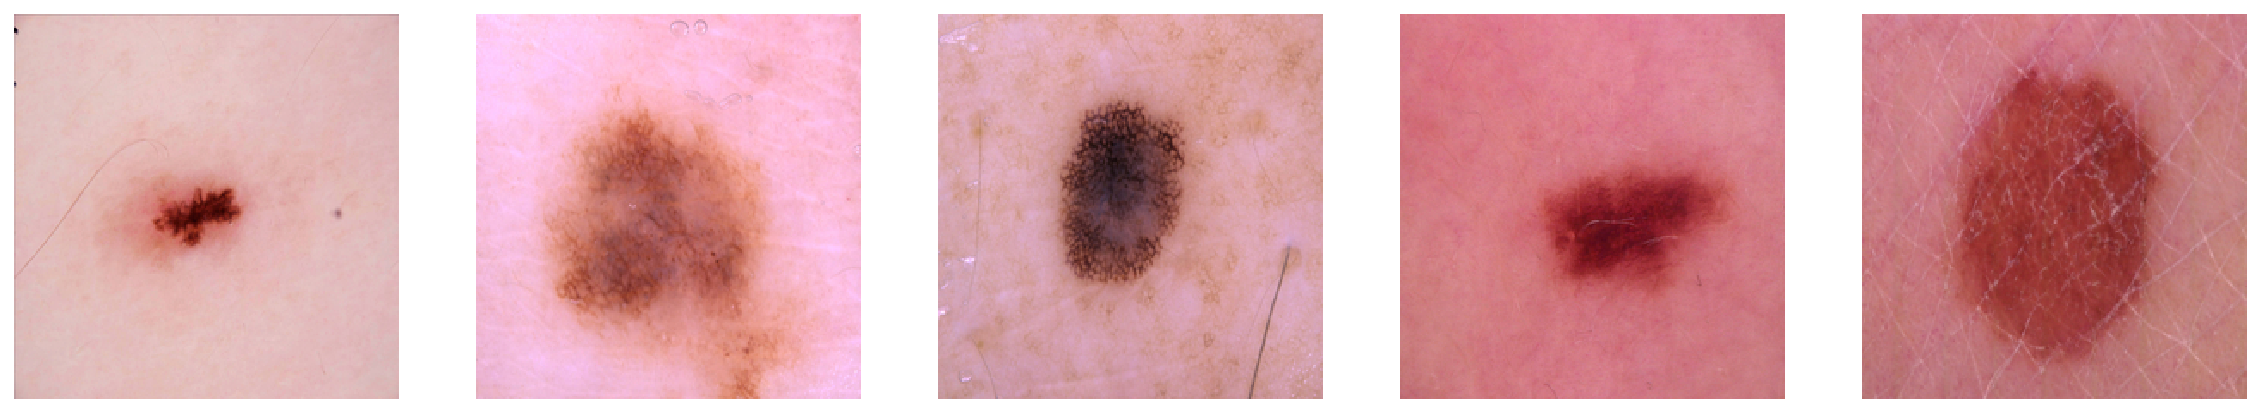

In [3]:
skinDataUtils.PrintMarkdownText('***Samples of the malignant (cancerous) tumors...***')
skinDataUtils.ReadAndDisplayInputImages(SKIN_CANCER_TUMOR_TYPE.BENIGN.value, 5)

<br>

***Samples of the benign (non-cancerous) tumors...***

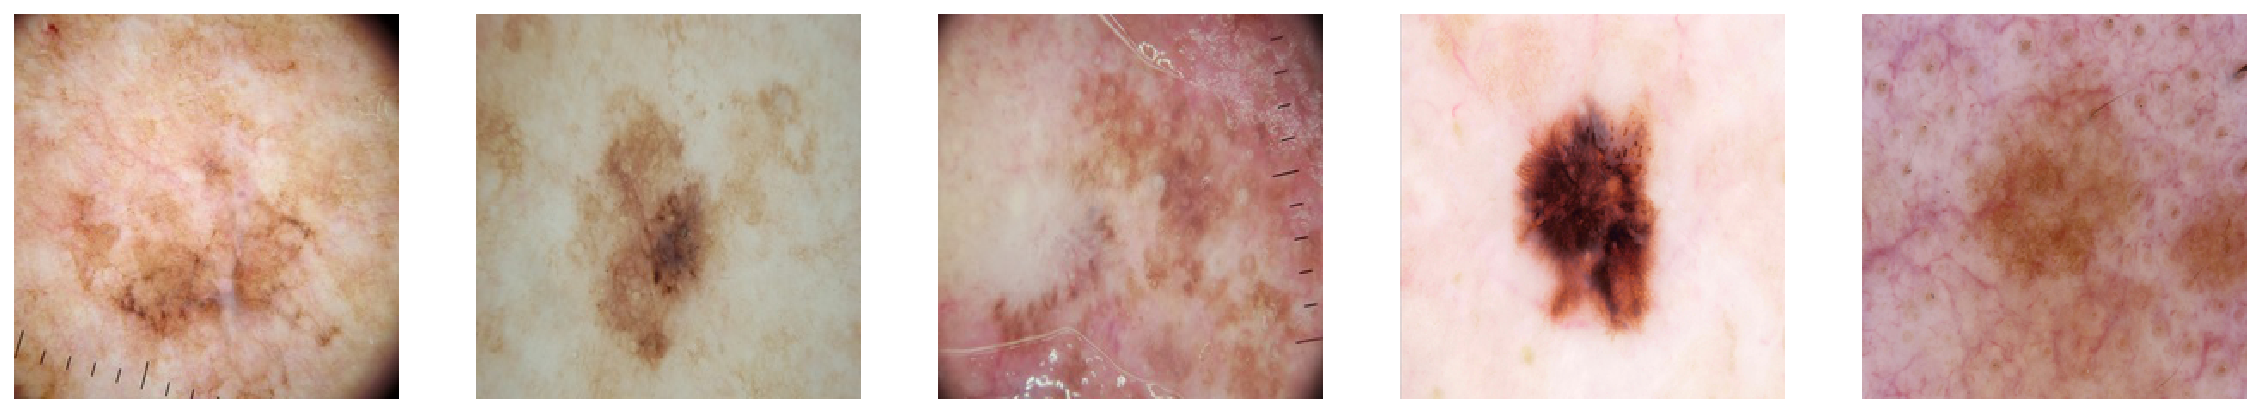

In [4]:
skinDataUtils.PrintMarkdownText('***Samples of the benign (non-cancerous) tumors...***')
skinDataUtils.ReadAndDisplayInputImages(SKIN_CANCER_TUMOR_TYPE.MALIGNANT.value, 5)

### Data Labelling

The images we have are un-labelled data. Deep learnins systems require proper annotated data to be able to learn the specific representations of each class and perform the job on unseen real time data. So, before proceeding with furtehr analysis we will first assign labels to our data. We have 2 class of images -

1. **Benign**

2. **Malignant**

***Malignant (cancerous)*** will be assigned values of 1 and ***Benign (non-cancerous)*** will be assigned the value 0.

In [5]:
skinCancer_df = skinDataUtils.GetLabelledSkinCancerData()

skinDataUtils.PrintMarkdownText('***Labelled skin cancer images...***')
skinCancer_df.head()

<br>

***Labelled skin cancer images...***

filename      label
0   ISIC Skin Cancer/images/malignant\507.jpg  Malignant
1  ISIC Skin Cancer/images/malignant\1465.jpg  Malignant
2      ISIC Skin Cancer/images/benign\820.jpg     Benign
3      ISIC Skin Cancer/images/benign\311.jpg     Benign
4  ISIC Skin Cancer/images/malignant\1068.jpg  Malignant

In [6]:
skinDataUtils.PrintMarkdownText('***Annotated skin cancer dataframe Info...***')
skinCancer_df.info()

<br>

***Annotated skin cancer dataframe Info...***

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3297 entries, 0 to 3296
Data columns (total 2 columns):
filename    3297 non-null object
label       3297 non-null object
dtypes: object(2)
memory usage: 51.6+ KB


<br>

***Sample Annotated Benign & Malignant Images...***

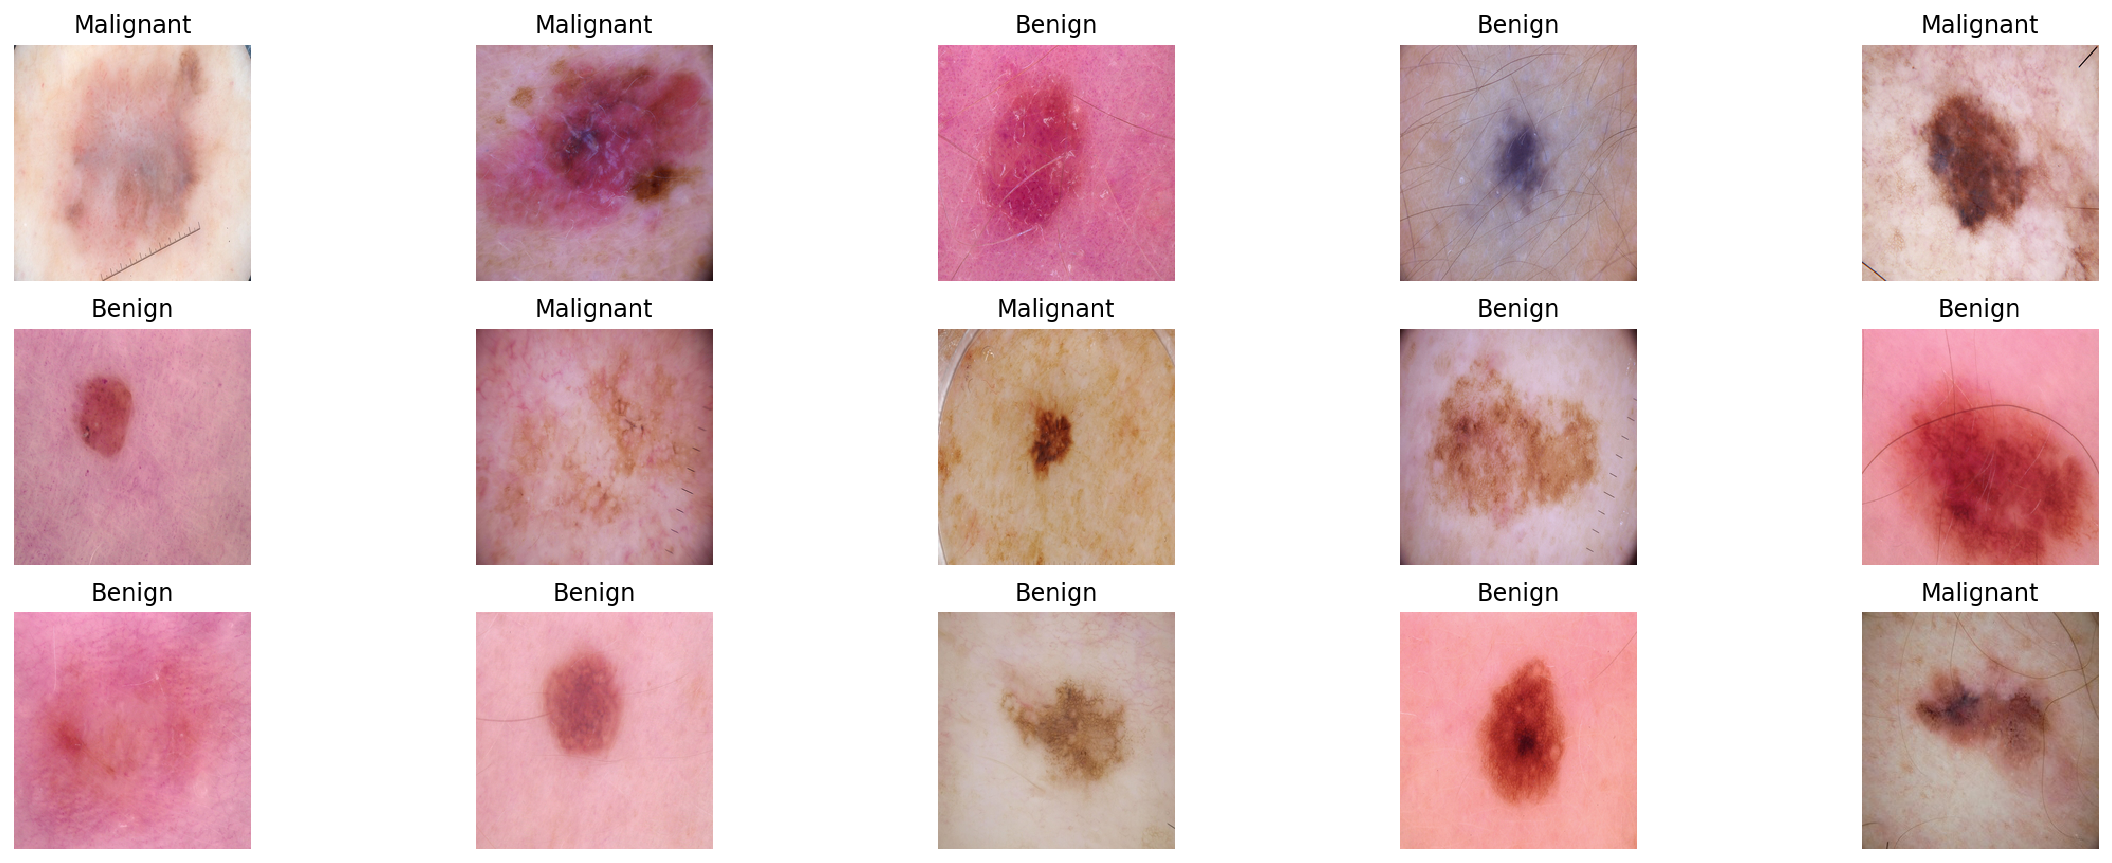

In [7]:
skinDataUtils.PrintMarkdownText('***Sample Annotated Benign & Malignant Images...***')
skinDataUtils.DisplayAnnotatedImages(skinCancer_df, 15)

In [8]:
skinDataUtils.PrintMarkdownText('***Shape Distribution for Malignant Images:***')
skinDataUtils.GetAllImageShape(SKIN_CANCER_TUMOR_TYPE.MALIGNANT.value)

<br>

***Shape Distribution for Malignant Images:***

Counter({(224, 224, 3): 1497})

In [9]:
skinDataUtils.PrintMarkdownText('***Shape Distribution for Benign Images:***')
skinDataUtils.GetAllImageShape(SKIN_CANCER_TUMOR_TYPE.BENIGN.value)

<br>

***Shape Distribution for Benign Images:***

Counter({(224, 224, 3): 1800})

All the images are of uniform dimension --> **(224, 224, 3)**

In [10]:
# train - test split
train_files, test_files, train_labels, test_labels = train_test_split(skinCancer_df['filename'].values,
                                                                      skinCancer_df['label'].values, 
                                                                      test_size=0.15, random_state=42)

# train - validation split
train_files, validation_files, train_labels, validation_labels = train_test_split(train_files,
                                                                    train_labels, 
                                                                    test_size=0.10, random_state=42)

In [11]:
skinDataUtils.PrintMarkdownText('***Length of the generated datasets...***')

print(" -- Train Set Length: " + str(len(train_files)) + ' samples'
      "\n -- Validation Set Length: "  + str(len(validation_files)) + ' samples'
      "\n -- Test Set Length: " + str(len(test_files)) + ' samples')

<br>

***Length of the generated datasets...***

 -- Train Set Length: 2521 samples
 -- Validation Set Length: 281 samples
 -- Test Set Length: 495 samples


In [12]:
# Get the Tally of occurrences of the 2 labels in the generated datasets...

skinDataUtils.PrintMarkdownText('***Tally of occurrences of the 2 labels in the generated datasets...***')

print('Training Data:', Counter(train_labels), 
      '\n\nValidation Data:', Counter(validation_labels), 
      '\n\nTest Data:', Counter(test_labels))

<br>

***Tally of occurrences of the 2 labels in the generated datasets...***

Training Data: Counter({'Benign': 1385, 'Malignant': 1136}) 

Validation Data: Counter({'Benign': 164, 'Malignant': 117}) 

Test Data: Counter({'Benign': 251, 'Malignant': 244})


In [15]:
# skinDataUtils.ReadAllImages

train_data = skinDataUtils.ReadAllImages(imageList = train_files, resizeImage = True, newImageSize = (135, 135))
validation_data = skinDataUtils.ReadAllImages(imageList = validation_files, resizeImage = True, newImageSize = (135, 135))
test_data = skinDataUtils.ReadAllImages(imageList = test_files, resizeImage = True, newImageSize = (135, 135))

In [16]:
X_test = test_data / 255.

### Label Encoding

Encode categorical values **(`'Benign' & 'Malingant'`)** to convert to the machine readable and interpretable values which would be **Benign - 0** and **Malignant - 1**.

In [17]:
lbl_encoder = LabelEncoder()
lbl_encoder.fit(train_labels)

y_train = lbl_encoder.transform(train_labels)
y_validation = lbl_encoder.transform(validation_labels)
y_test = lbl_encoder.transform(test_labels)

skinDataUtils.PrintMarkdownText('***Categorical & Encoded Training Labels...***')
print("Categorical Train Labels:", list(train_labels[:5]), 
      "\n\nEncoded Train Labels:    ", y_train[:5])

<br>

***Categorical & Encoded Training Labels...***

Categorical Train Labels: ['Benign', 'Malignant', 'Benign', 'Malignant', 'Benign'] 

Encoded Train Labels:     [0 1 0 1 0]


## Model Training and Validation

In [18]:
# Training Parameters
BATCH_SIZE = 32
NUM_CLASSES = 2
EPOCHS = 30
INPUT_SHAPE = (135, 135, 3)

In [19]:
def BuildSkinCancerDetectionModel(INPUT_SHAPE = INPUT_SHAPE):

    model = Sequential(name = 'SkinCancerDetectionModel')

    model.add(Conv2D(32, (3,3), padding='same',input_shape = INPUT_SHAPE))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(256, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(GlobalAveragePooling2D(data_format='channels_last'))
#     model.add(Dropout(0.5))
#     model.add(BatchNormalization())
    
    model.add(Dense(1,activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    # metrics = ['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), 
    # keras.metrics.AUC(), keras.metrics.AUC(curve='PR')]

    print(model.summary())
    return model

In [20]:
skinCancerDetectModel = BuildSkinCancerDetectionModel()

Model: "SkinCancerDetectionModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 135, 135, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 135, 135, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 135, 135, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 67, 67, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 67, 67, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 67, 67, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 67, 67

In [21]:
CallBackList = ModelTrainer.GetCallBackList("SkinCancerDetectionModel")
ModelTrainer.PrintModelCallBacks(CallBackList)

Model Checkpoint (.h5 file) Path: ./SkinCancerDetectionModel.h5


<br>

***Model Callback List...***

1. <tensorflow.python.keras.callbacks.ModelCheckpoint object at 0x0000022BEA8EA7B8>
2. <tensorflow.python.keras.callbacks.EarlyStopping object at 0x0000022BEA8EA3C8>
3. <tensorflow.python.keras.callbacks.ReduceLROnPlateau object at 0x0000022BEA8EAAC8>


In [22]:
train_gen, val_gen = ModelTrainer.GetImageDataGenerators(train_data, y_train, validation_data, y_validation, BATCH_SIZE)

In [23]:
Model_Train_History = ModelTrainer.fit_generator(skinCancerDetectModel,
                                                 train_gen, 
                                                 EPOCHS, 
                                                 val_gen, 
                                                 CallBackList)

<br>

***Model Training Started...***

Epoch 1/30
78/78 [==============================] - 135s 2s/step - loss: 0.4826 - accuracy: 0.7802 - val_loss: 0.6570 - val_accuracy: 0.5938

Epoch 00001: val_loss improved from inf to 0.65697, saving model to .\SkinCancerDetectionModel.h5
Epoch 2/30
78/78 [==============================] - 133s 2s/step - loss: 0.4116 - accuracy: 0.7983 - val_loss: 0.6398 - val_accuracy: 0.6094

Epoch 00002: val_loss improved from 0.65697 to 0.63976, saving model to .\SkinCancerDetectionModel.h5
Epoch 3/30
78/78 [==============================] - 131s 2s/step - loss: 0.3972 - accuracy: 0.8007 - val_loss: 0.5882 - val_accuracy: 0.6641

Epoch 00003: val_loss improved from 0.63976 to 0.58819, saving model to .\SkinCancerDetectionModel.h5
Epoch 4/30
78/78 [==============================] - 130s 2s/step - loss: 0.3981 - accuracy: 0.8035 - val_loss: 0.4811 - val_accuracy: 0.7227

Epoch 00004: val_loss improved from 0.58819 to 0.48109, saving model to .\SkinCancerDetectionModel.h5
Epoch 5/30
78/78 [==========

<br>

***Monitoring Model Train History...***

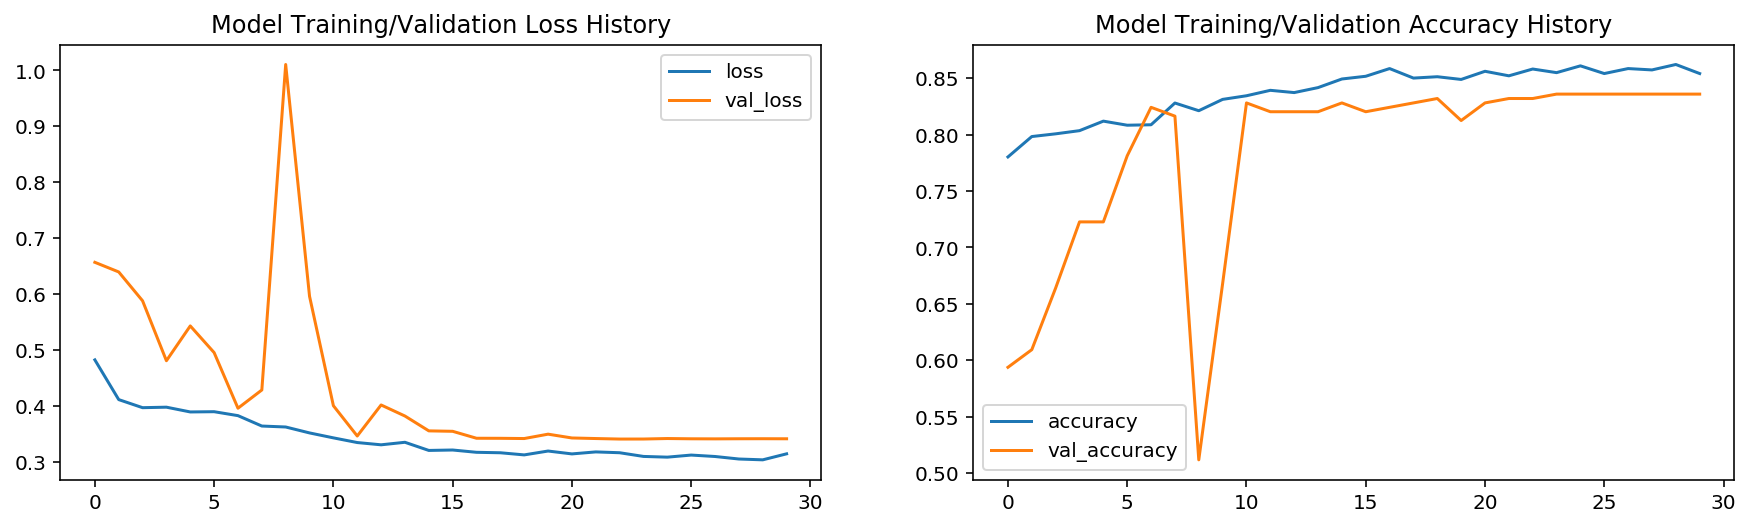

In [24]:
ModelTrainer.plot_model_history(Model_Train_History)

In [ ]:
# skinCancerDetectModel = ValidateSkinCancerClassfier.load_model("models/SkinCancerDetectionModel.h5")

In [25]:
y_preds_probability, y_preds_binary = ValidateSkinCancerClassfier.GetModelPredictions(skinCancerDetectModel, X_test)

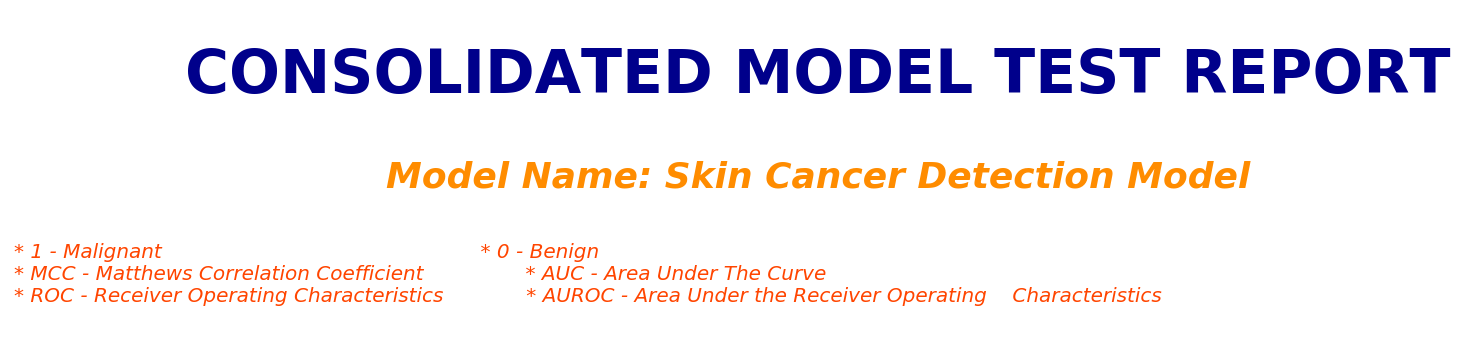

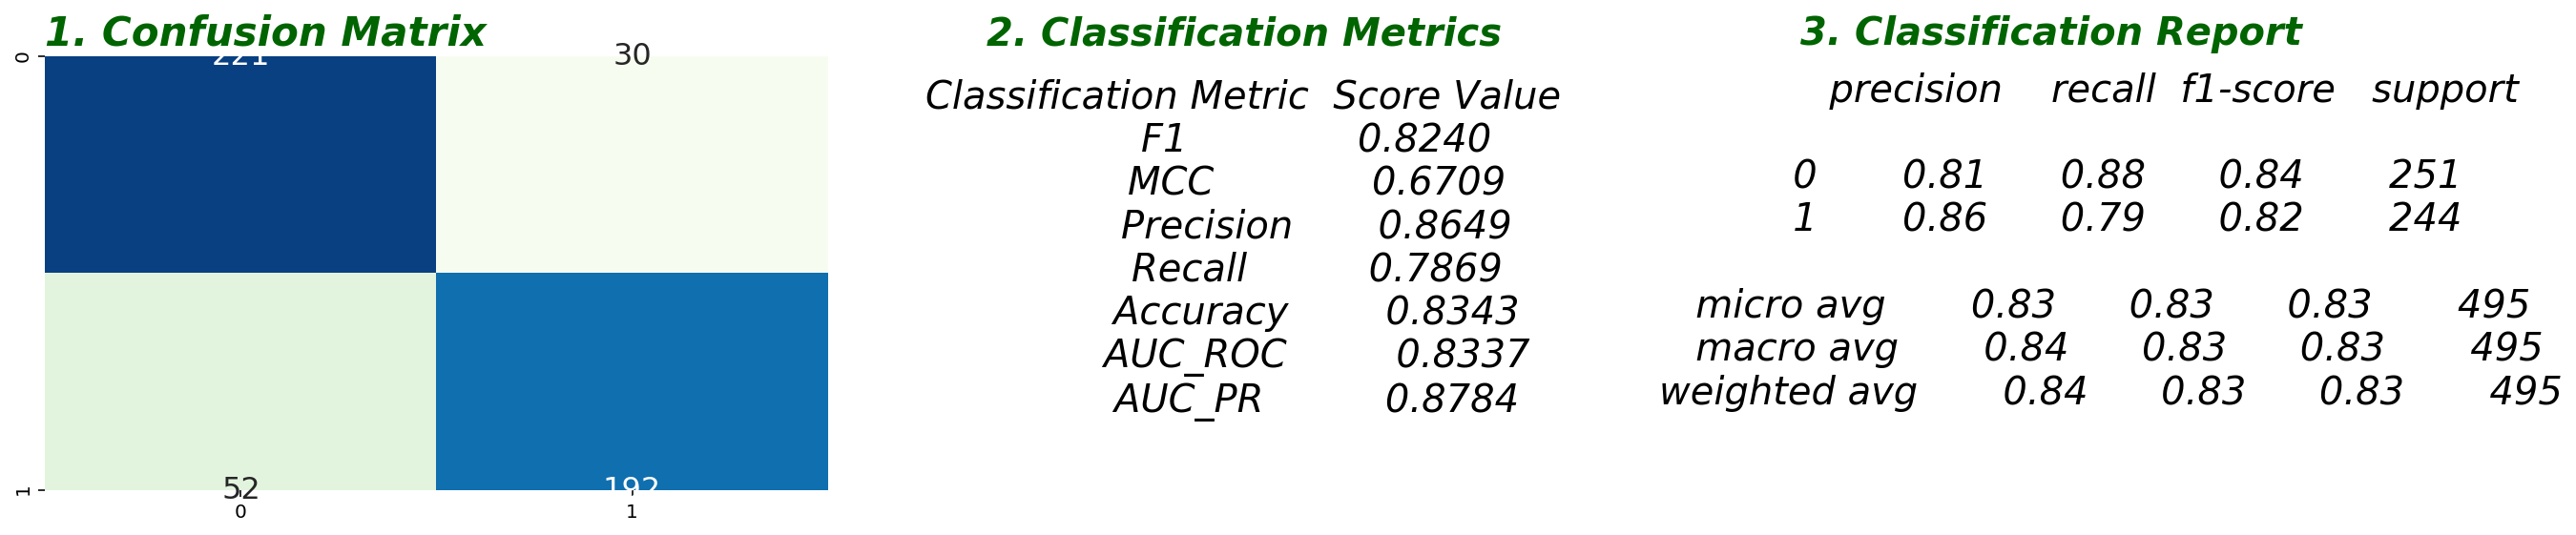

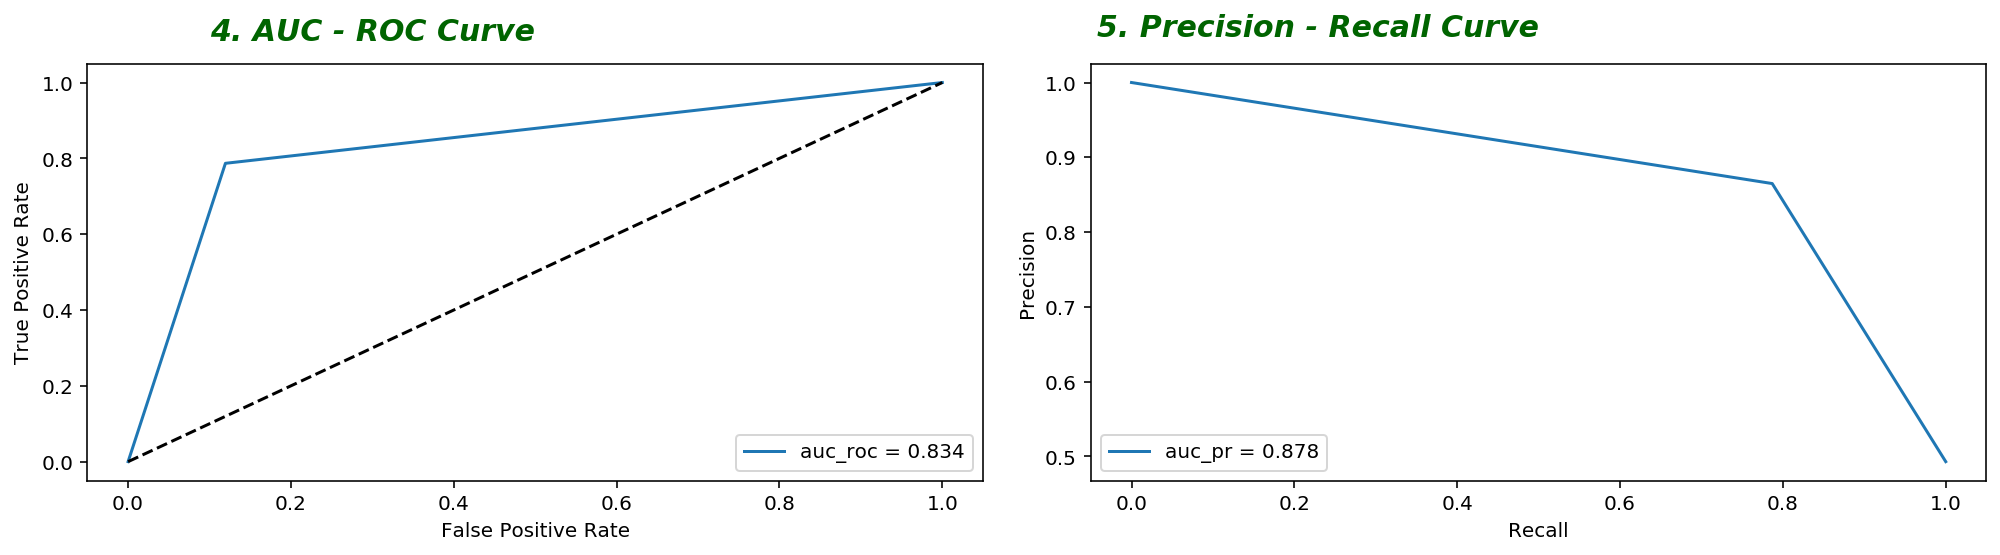

In [26]:
ValidateSkinCancerClassfier.Generate_Model_Test_Classification_Report(y_test, 
                                                                      y_preds_binary, 
                                                                      "Skin Cancer Detection Model")

<br>

***Model test results of 16 random test images...***

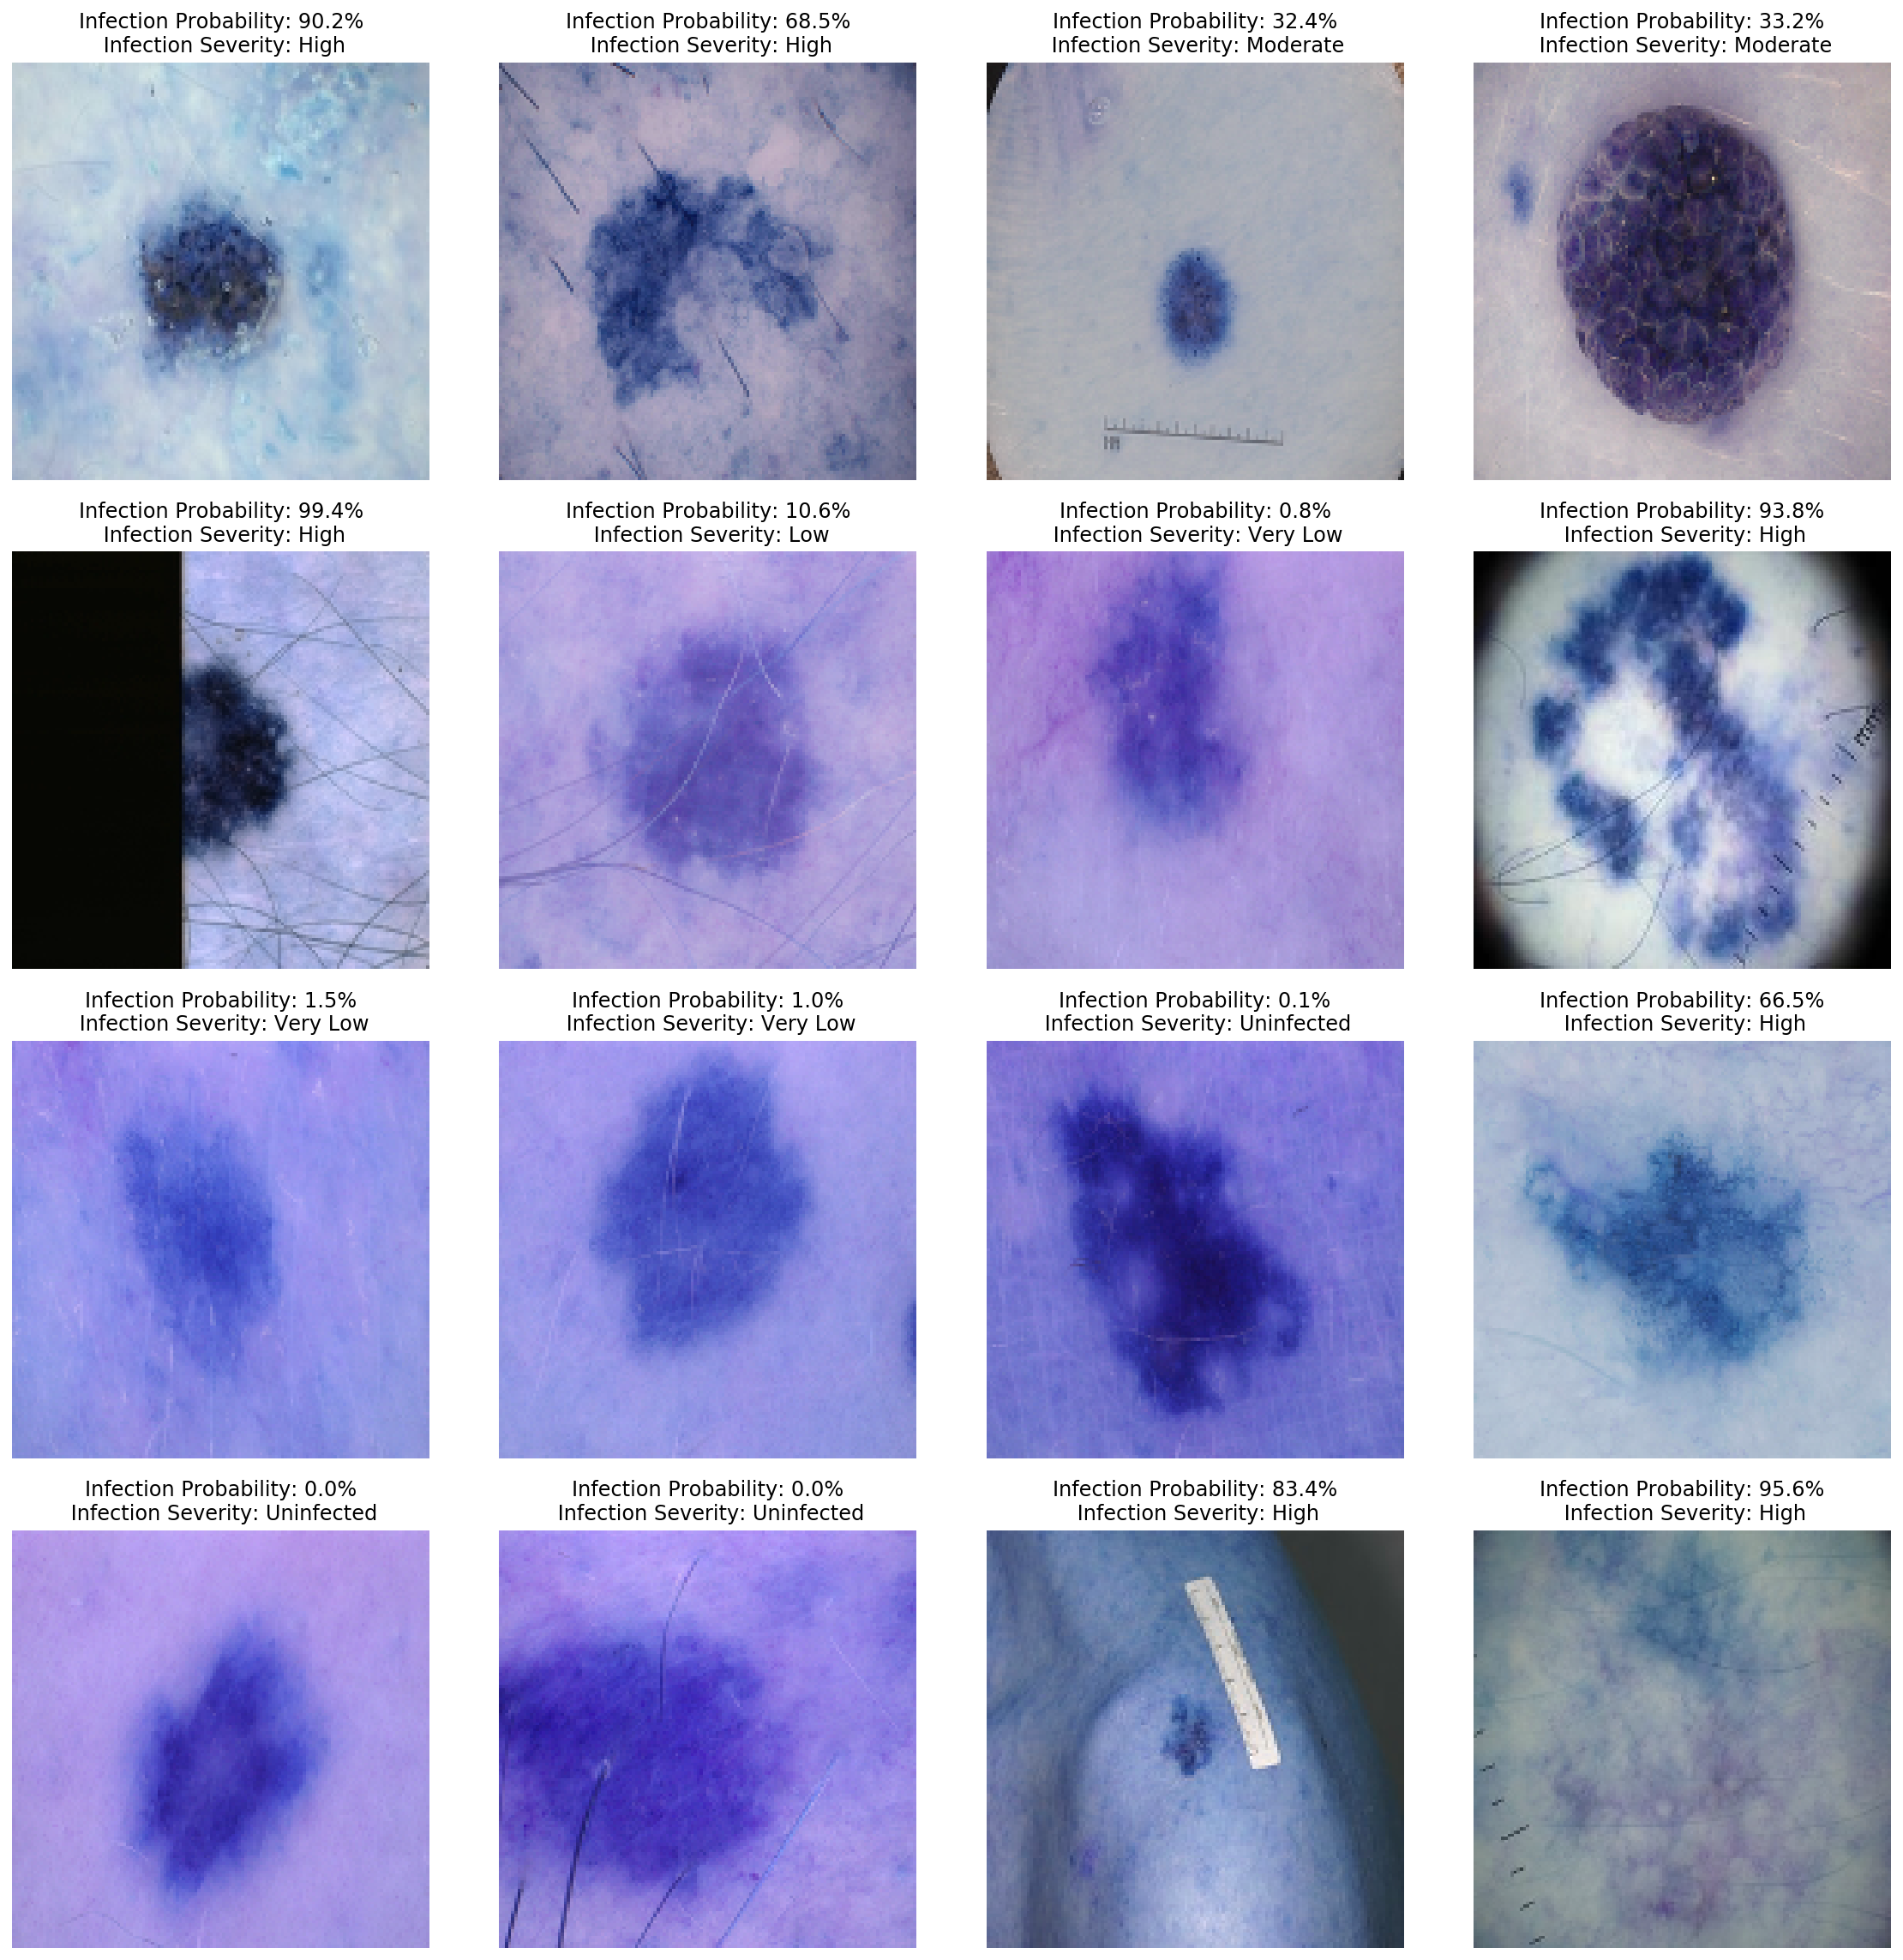

In [32]:
ValidateSkinCancerClassfier.PlotModelPredictionsOnRandomTestImages(X_test, y_test, y_preds_probability)

In [ ]:
# for layer in skinCancerDetectModel.layers:
#     print(layer.name)

In [27]:
# Get the last layer of the convolutional block
last_conv_layer_name = "batch_normalization_3"

# Get the final classification layers
classifier_layer_names = [
    "global_average_pooling2d",
    "dense",
]

In [28]:
# Prepare the image for prediction and computation of activation maps. 
# As the models needs batch of images, the images are converted to a 4d tensor of shape (1, 135, 135, 3).
img1 = ValidateSkinCancerClassfier.PrepareImageForPrediction(X_test[22])
img2 = ValidateSkinCancerClassfier.PrepareImageForPrediction(X_test[24])
img3 = ValidateSkinCancerClassfier.PrepareImageForPrediction(X_test[25])

In [29]:
from GradCamUtility import GradCamUtils
ModelActivations = GradCamUtils()

# Get the Grad-CAM heatmap for each imagefrom the grdient output of the last convolutional layer.
heatmap1 = ModelActivations.ComputeGradCAMHeatmap(img1, skinCancerDetectModel, last_conv_layer_name, classifier_layer_names)
heatmap2 = ModelActivations.ComputeGradCAMHeatmap(img2, skinCancerDetectModel, last_conv_layer_name, classifier_layer_names)
heatmap3 = ModelActivations.ComputeGradCAMHeatmap(img3, skinCancerDetectModel, last_conv_layer_name, classifier_layer_names)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


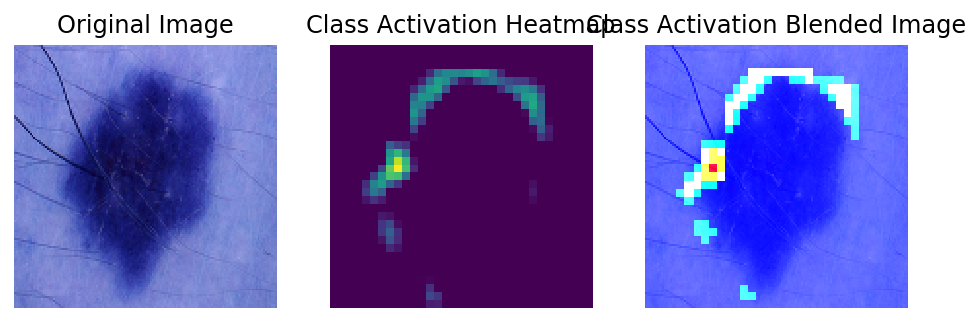

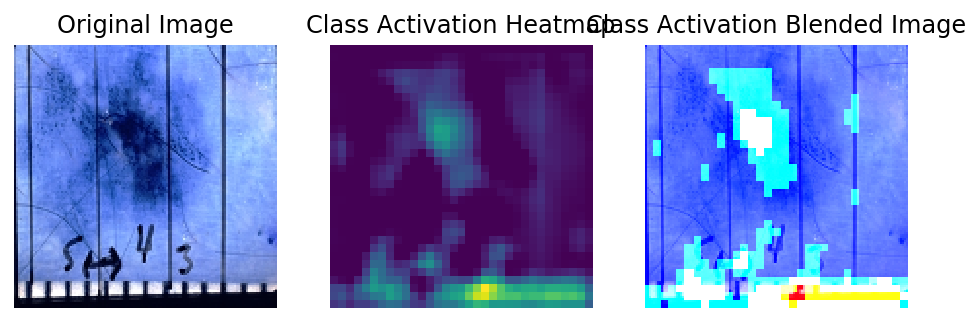

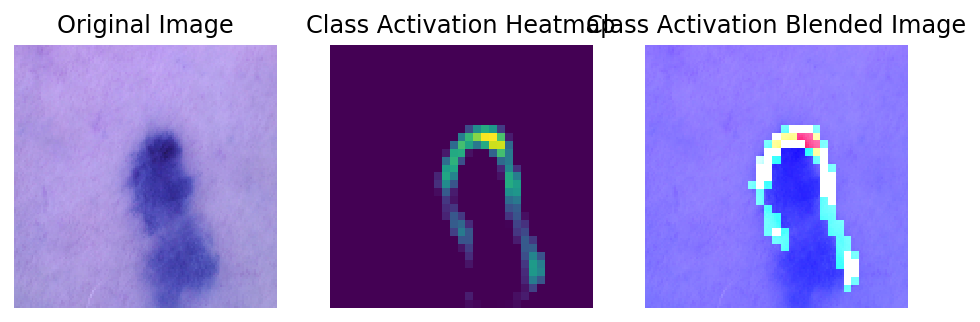

In [31]:
# Get the superimposed images...
super_imposed_image1 = ModelActivations.GetSuperImposedCAMImage(heatmap1, X_test[22])
super_imposed_image2 = ModelActivations.GetSuperImposedCAMImage(heatmap2, X_test[24])
super_imposed_image3 = ModelActivations.GetSuperImposedCAMImage(heatmap3, X_test[25])

# Display the heatmap and the super-imposed images
ModelActivations.DisplaySuperImposedImages(X_test[22], heatmap1, super_imposed_image1)
ModelActivations.DisplaySuperImposedImages(X_test[24], heatmap2, super_imposed_image2)
ModelActivations.DisplaySuperImposedImages(X_test[25], heatmap3, super_imposed_image3)

### EfficientNetB0

In [ ]:
def GetEfficientNetB0Model(INPUT_SHAPE=(224, 224, 3), bTrainConvolutionBase=False):
        
    conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=INPUT_SHAPE)

    if bTrainConvolutionBase == False:
        for layer in conv_base.layers:
            layer.trainable = False

    dropout_rate = 0.3
    EfficientNetB0_TL_Model = Sequential(name='Transfer_Learning_EfficientNet_B0')
    EfficientNetB0_TL_Model.add(conv_base)

    EfficientNetB0_TL_Model.add(GlobalAveragePooling2D(name="GAP"))

    EfficientNetB0_TL_Model.add(Dense(1, activation="sigmoid", name="fc_out"))

    EfficientNetB0_TL_Model.compile(optimizer='adam',
                                    loss='binary_crossentropy',
                                    metrics=['accuracy'])

    print(EfficientNetB0_TL_Model.summary())
    return EfficientNetB0_TL_Model

In [ ]:
skinCancerDetect_TL_Model = GetEfficientNetB0Model()

In [ ]:
CallBackList = ModelTrainer.GetCallBackList("SkinCancerDetection_EB0_Model")
ModelTrainer.PrintModelCallBacks(CallBackList)

In [ ]:
train_gen, val_gen = ModelTrainer.GetImageDataGenerators(train_data, y_train, validation_data, y_validation, BATCH_SIZE)

In [ ]:
TL_Model_Train_History = ModelTrainer.fit_generator(skinCancerDetect_TL_Model,
                                                 train_gen, 
                                                 EPOCHS, 
                                                 val_gen, 
                                                 CallBackList)

In [ ]:
ModelTrainer.plot_model_history(TL_Model_Train_History)

In [ ]:
y_preds_probability, y_preds_binary = ModelValidator.GetModelPredictions(skinCancerDetect_TL_Model, X_test)

In [ ]:
ValidateSkinCancerClassfier.Generate_Model_Test_Classification_Report(y_test, 
                                                                      y_preds_binary, 
                                                                      "Skin Cancer Detection Model")